Unique values in 'Sample' before mapping: ['Normal' 'Disease']
y_test: 0    0
1    0
2    0
3    0
4    1
Name: Sample, dtype: int64
Mapped y_pred: 0    0
1    0
2    0
3    0
4    1
dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.75      0.86         8

    accuracy                           0.92        26
   macro avg       0.95      0.88      0.90        26
weighted avg       0.93      0.92      0.92        26

Confusion Matrix:
[[18  0]
 [ 2  6]]
ROC-AUC Score: 1.00


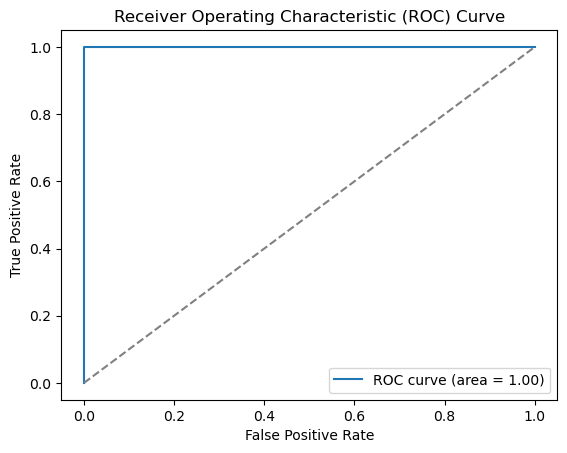

In [1]:
import pandas as pd
import logging
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib

# Set up logging configuration to record logs for troubleshooting and tracking
logging.basicConfig(
    filename="automation_system.log",
    level=logging.INFO,
    format="%(asctime)s:%(levelname)s:%(message)s",
)

# Step 1: Data Loading Function
def load_data(file_path):
    """Loads the dataset from an Excel file."""
    logging.info(f"Loading data from {file_path}")
    try:
        # Load Excel file into a Pandas DataFrame
        df = pd.read_excel(file_path)
        logging.info(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        # Log the error and exit if the file loading fails
        logging.error(f"Error loading data: {e}")
        sys.exit(1)

# Step 2: Data Preprocessing Function
def preprocess_data(df):
    """Preprocesses the data: handles missing values, cleans labels, and scales features."""
    logging.info("Starting data preprocessing")
    
    # Check for missing values in the features
    missing_values = df.isnull().sum().sum()
    if missing_values > 0:
        logging.warning(f"Data contains {missing_values} missing values. Filling with mean.")
        df.fillna(df.mean(), inplace=True)

    # Clean the 'Sample' column (target) to standardize labels
    df['Sample'] = df['Sample'].str.strip().str.capitalize()  

    # Ensure labels are only 'Disease' and 'Normal'
    print("Unique values in 'Sample' before mapping:", df['Sample'].unique())

    # Separate features (X) and target (y)
    X = df.drop('Sample', axis=1)
    y = df['Sample'].map({'Disease': 1, 'Normal': 0})  

    # Check if mapping resulted in NaNs
    if y.isnull().sum() > 0:
        print("Warning: Some labels could not be mapped. Check the 'Sample' column for unrecognized labels.")
        print("Rows with NaN in 'y':", df[y.isnull()])

    # Standardize features (X) using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    logging.info("Data preprocessing completed")
    
    return X_scaled, y, scaler

# Step 3: Model Training Function
def train_model(X_train, y_train):
    """Trains the Random Forest classifier."""
    logging.info("Training the Random Forest classifier")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    logging.info("Model training completed")
    return model

# Step 4: Model Evaluation Function with Debugging
def evaluate_model(model, X_test, y_test):
    """Evaluates the trained model on the test set."""
    logging.info("Evaluating the model")

    # Ensure y_test is already numeric and mapped correctly
    print("y_test:", y_test.head())

    # Predict the class labels and probabilities
    y_pred = model.predict(X_test)
    
    # Convert predicted labels to numeric values
    y_pred_numeric = pd.Series(y_pred)

    # Check if predicted mapping worked
    print("Mapped y_pred:", y_pred_numeric.head())

    # Ensure both are numeric and the evaluation proceeds
    if y_test is not None and y_pred_numeric is not None:
        # Classification Report
        report = classification_report(y_test, y_pred_numeric)
        logging.info(f"Classification Report:\n{report}")
        print("Classification Report:")
        print(report)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_numeric)
        logging.info(f"Confusion Matrix:\n{cm}")
        print("Confusion Matrix:")
        print(cm)

        # ROC-AUC Score
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        logging.info(f"ROC-AUC Score: {roc_auc:.2f}")
        print(f"ROC-AUC Score: {roc_auc:.2f}")

        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.savefig('roc_curve.png')
        logging.info("ROC curve plotted and saved as roc_curve.png")
    else:
        print("Error: y_test or y_pred_numeric is None")

# Step 5: Save Model Function
def save_model(model, scaler, model_path='model.joblib', scaler_path='scaler.joblib'):
    """Saves the trained model and scaler to disk."""
    joblib.dump(model, model_path)
    logging.info(f"Model saved to {model_path}")
    joblib.dump(scaler, scaler_path)
    logging.info(f"Scaler saved to {scaler_path}")

# Main Automation Function
def main():
    """Main function to run the full automation process."""
    # Specify the path 
    data_file = '/Users/niveditasaha/Downloads/NEW DATA/Final_structured data.xlsx'  

    # Check if the data file exists
    if not os.path.exists(data_file):
        logging.error(f"Data file {data_file} does not exist.")
        sys.exit(1)

    # Load the data
    df = load_data(data_file)

    # Preprocess the data
    X, y, scaler = preprocess_data(df)

    # Split the data into training and testing sets (70% train, 30% test), using stratification
    logging.info("Splitting data into training and testing sets with stratification")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Reset index to ensure alignment
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Train the model
    model = train_model(X_train, y_train)

    # Evaluate the model
    evaluate_model(model, X_test, y_test)

    # Save the model and scaler
    save_model(model, scaler)

    logging.info("Automation process completed successfully")

# Entry point for the automation system
if __name__ == '__main__':
    main()
